In [1]:
import sys
from os import getenv
sys.path.append(getenv("DEVENV_ROOT"))

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import seaborn as sns
import pendulum
import greenflow.analysis as an
from entrypoint import load_gin
from greenflow.utils import convert_to_mib
import qgridnext as qgrid

cutoff_begin = "2025-01-11T06:15:35.626996+01:00"
cutoff_end = pendulum.now().to_iso8601_string()
# cutoff_end = "2025-02-12T14:10:59.432181+01:00"
print(cutoff_end)

load_gin(exp_name="ingest-kafka", test=False)

2025-02-18T22:53:50.051938+01:00


[WARNING]: failed to patch stdout/stderr for fork-safety: 'OutStream' object
has no attribute 'buffer'
[WARNING]: failed to reconfigure stdout/stderr with custom encoding error
handler: 'OutStream' object has no attribute 'reconfigure'


In [2]:
def plot_throughput_vs_replicas(enriched_data: pd.DataFrame):
    redpanda_df = enriched_data[enriched_data["exp_name"] == "ingest-redpanda"]
    kafka_df = enriched_data[enriched_data["exp_name"] == "ingest-kafka"]
    # sns.barplot(data=enriched_data, x='broker_replicas', y='throughput_MBps', hue='System')
    # Show values for points
    sns.lineplot(data=enriched_data, x='broker_replicas', y='throughput_MBps', hue='System')
    # for i in range(len(enriched_data)):
    #     plt.text(enriched_data['broker_replicas'].iloc[i], enriched_data['throughput_MBps'].iloc[i], enriched_data['throughput_MBps'].iloc[i], ha='center', va='bottom')
    # plt.title('Throughput vs Brokers (Kafka - HDD)')
    plt.xlabel('Brokers')
    plt.ylabel('Data Throughput (MBps)')
    plt.grid(True)
    sns.despine()
    plt.show()
    # sns.boxplot(data=kafka_df, x='broker_replicas', y='throughput_MBps')


In [ ]:
df = an.full_analytical_pipeline(
    cutoff_begin=cutoff_begin,
    cutoff_end=cutoff_end,
    # exp_name="ingest-kafka",
    # cluster=".*",
    cluster="ecotype",
    # cluster="grappe",
    # type="scalingBehaviour",
    type=".*",
    load=10**9,
    replicationFactor=3,
    messageSize=32,
    consumer_instances=0,
    # messageSize=128,
)
system_mapping = {
    'ingest-kafka': 'Kafka',
    'ingest-redpanda': 'Redpanda'
}
cluster_mapping = {
    'ovhnvme': 'ADVANCE',
    'taurus': 'Taurus',
    'grappe': 'Grappe',
    'ecotype': 'Ecotype',
    'parasilo': 'Parasilo',
    'parasilohdd': 'ParasiloHDD',
}
# ovhnvme = ovhnvme.copy()
df['System'] = df['exp_name'].map(system_mapping)
df['Cluster'] = df['cluster'].map(cluster_mapping)
df_orig = df.copy()
df = df[~((df['System'] == 'Redpanda') & (df['Cluster'] == 'Taurus'))]
df = df.dropna()
df = df[df['partitions'] == df['broker_replicas'] * 10]
df = df[df['producer_instances'] == df['broker_replicas'] * 10]
# df = df[df['System'] == 'Kafka']
df = df[df['consumer_instances'] == 0]
# df = df[df.num_worker_nodes > 1] 
# taurus_kafka = an.full_analytical_pipeline(
#     cutoff_begin=cutoff_begin, cutoff_end=cutoff_end, exp_name="ingest-kafka", cluster="taurus", type="scalingBehaviour", partitions=120,
# )

an.create_qgrid_widget(df)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

<Axes: xlabel='broker_replicas', ylabel='adjusted_network_throughput'>

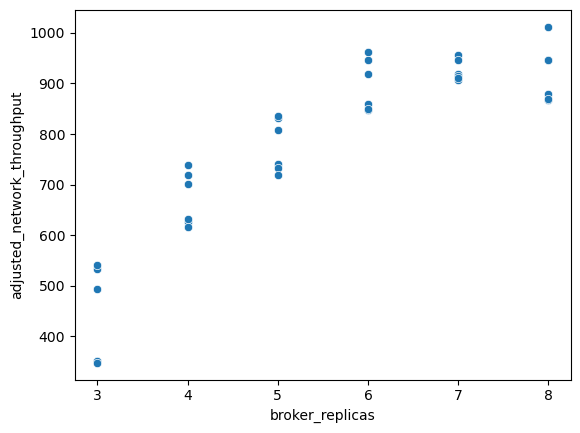

In [4]:
sns.scatterplot(
    df,
    x='broker_replicas',
    y='adjusted_network_throughput',)

In [5]:
# a = df.copy()
# a.drop(
#     [
#         "exp_name",
#         "cluster",
#         # "broker_replicas",
#         "broker_cpu",
#         "broker_mem",
#         "producer_instances",
#         "consumer_instances",
#         "duration",
#         "durationSeconds",
#         "latency_p99",
#         "load",
#         "messageSize",
#         "num_broker_nodes",
#         "partitions",
#         "replicationFactor",
#         # "throughput_per_watt",
#         "energy_cost",
#         "network_saturation",
#         "average_power",
#         "started_ts",
#         "stopped_ts",
#         "observed_throughput",

#     ],
#     axis=1,
#     inplace=True,
# )
# an.create_qgrid_widget(a)
# print(a.to_csv(index=False))

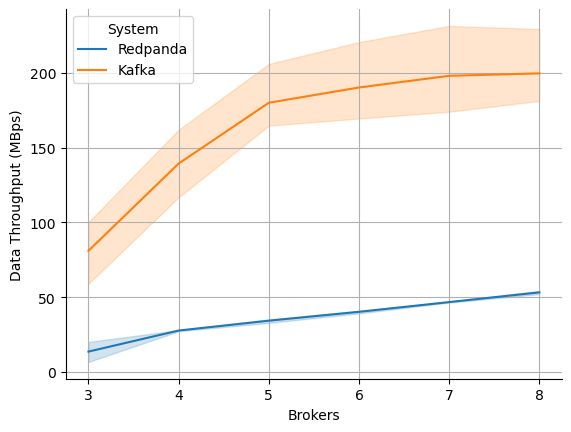

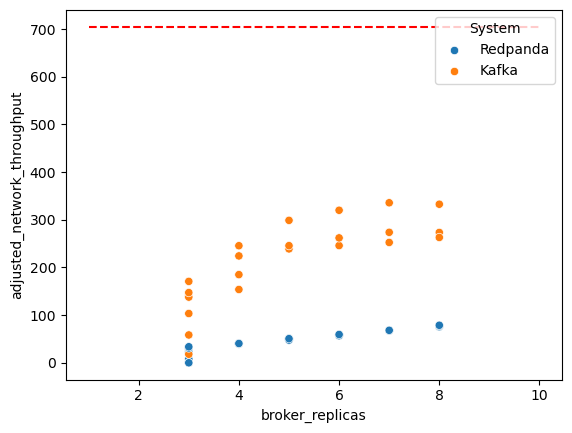

In [6]:
plot_throughput_vs_replicas(df_orig[df_orig['Cluster'] == 'Taurus'])
ax = sns.scatterplot(
    df_orig[df_orig["Cluster"] == "Taurus"],
    x="broker_replicas",
    y="adjusted_network_throughput",
    hue="System",
)
ax.hlines(352.5*2, 1, 10, colors="red", linestyles="--")
plt.show()

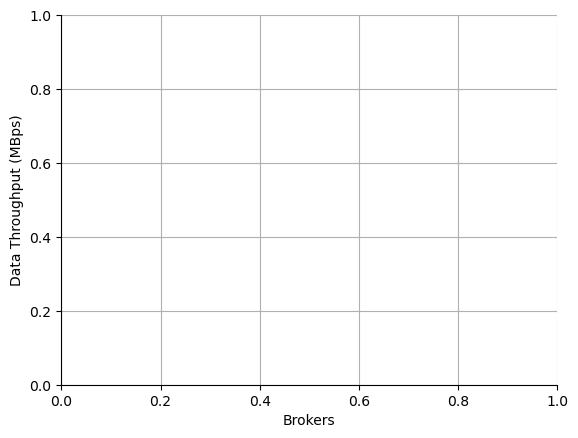

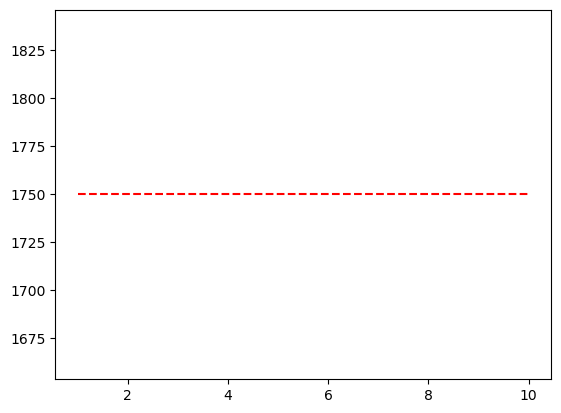

In [7]:
plot_throughput_vs_replicas(df[df["Cluster"] == "Grappe"])
ax = sns.scatterplot(
    df[df["Cluster"] == "Grappe"],
    x="broker_replicas",
    y="adjusted_network_throughput",
    hue="System",
)
ax.hlines(875*2, 1, 10, colors="red", linestyles="--")
plt.show()

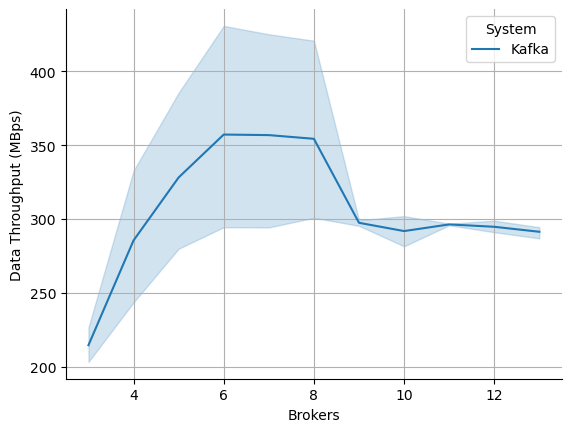

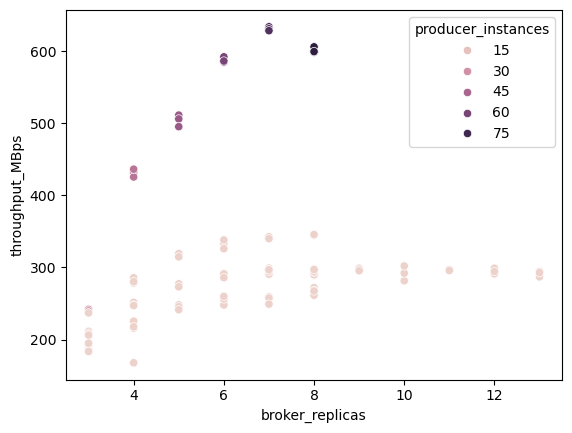

In [15]:
interest = df_orig[(df_orig["Cluster"] == "Ecotype") & (df_orig["System"] == "Kafka")]
# interest = interest[interest["messageSize"] == 128]
plot_throughput_vs_replicas(interest)
ax = sns.scatterplot(
    interest,
    x="broker_replicas",
    # y="adjusted_network_throughput",
    y="throughput_MBps",
    hue="producer_instances",
    # hue="System",
)
# ax.hlines(575*2, 1, 10, colors="red", linestyles="--")

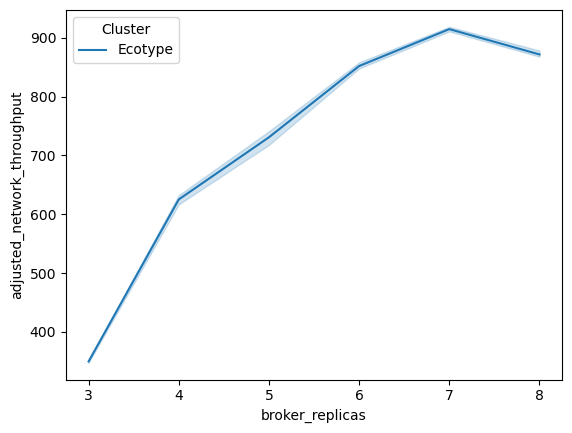

In [9]:
kafka_df = df[df['System'] == 'Kafka']
kafka_df = kafka_df[((kafka_df['Cluster'] == 'Ecotype') | (kafka_df['Cluster'] == 'Grappe'))]
ax = sns.lineplot(
    kafka_df,
    x='broker_replicas',
    # y='throughput_MBps',
    y='adjusted_network_throughput',
    hue="Cluster",
    )
# ax.hlines(100, 0, 10, colors='r', linestyles='dashed')

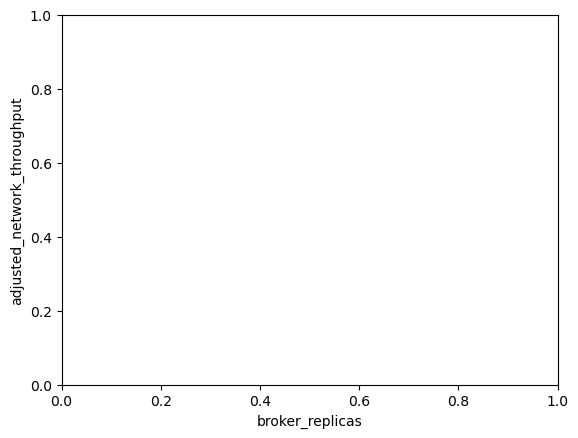

In [10]:
kafka_df = df[df['System'] == 'Kafka']
kafka_df = kafka_df[((kafka_df['Cluster'] == 'Parasilo') | (kafka_df['Cluster'] == 'Grappe'))]
ax = sns.lineplot(
    kafka_df,
    x='broker_replicas',
    y='adjusted_network_throughput',
    hue="Cluster",
    )


Cluster,3,4,5,6,7,8
Ecotype,0.0,2.3619665684622992,0.906393228830718,1.0391068204203788,0.5377325746082451,-0.369052818693149



/tmp/ipykernel_1475407/892322805.py:90: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  aggregated['incremental_throughput'][aggregated.index.get_level_values('broker_replicas') == 3] = 0


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

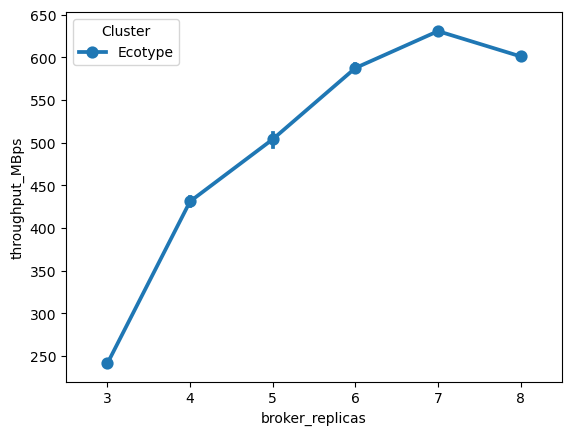

In [11]:
from math import sqrt
import numpy as np


kafka_df = df[df['System'] == 'Kafka']
# kafka_df = kafka_df[((kafka_df['Cluster'] == 'ParasiloHDD') | (kafka_df['Cluster'] == 'Parasilo'))]
ax = sns.pointplot(
    kafka_df,
    x='broker_replicas',
    # y='adjusted_network_throughput',
    y='throughput_MBps',
    hue="Cluster",
    )

def model(replicas, t3, overhead_factor=0.22):
    from math import sqrt
    return replicas * t3 * (1+3*overhead_factor)/3/(1+(overhead_factor * sqrt(replicas)))

def model(replicas, m=40.32283, c=224.9732):
    # y = 40.32283*x + 224.9732
    from math import sqrt
    return m * replicas + c

def model(replicas, m=167.44, c=54.04):
    # y = 40.32283*x + 224.9732
    from math import sqrt
    return m * sqrt(replicas) + c

def predict_throughput(replicas, t3, a=1.0):
    """
    Predict throughput using the corrected model:
    T_max(n) = a * t3 * (1 + sqrt(n))
    
    Parameters:
    - replicas: number of broker replicas
    - t3: throughput of 3-broker configuration
    - a: scaling coefficient (default 1.0)
    """
    return a * t3 * (1 + sqrt(replicas))


kafka_df = kafka_df[kafka_df['Cluster'] != 'ADVANCE']
aggregated = (
    kafka_df.groupby(['Cluster', 'broker_replicas'])
    .agg(
        mean_throughput=('throughput_MBps', 'mean'),
        # std_throughput=('throughput_MBps', 'std'),
        # count=('throughput_MBps', 'size')
    )
)

# base throughput is the throughput of the smallest configuration divided by 3
aggregated['base_throughput'] = aggregated['mean_throughput'][aggregated.index.get_level_values('broker_replicas') == 3].values[0] / 3
# Get ratio between throughput and replicas
aggregated['throughput_per_replica'] = aggregated['mean_throughput'] / aggregated.index.get_level_values('broker_replicas')


# Get incremental throughput
aggregated['incremental_throughput'] = aggregated['mean_throughput'].diff()
# Normalize it by the base value
aggregated['incremental_throughput'] = aggregated['incremental_throughput'] / aggregated['base_throughput']
# Get t3 (throughput of 3-broker configuration)
# Get t3 values for each cluster
t3_values = {}
for cluster in aggregated.index.get_level_values('Cluster').unique():
    if cluster == 'Grappe' or cluster == 'Parasilo':
        pass
    t3_values[cluster] = aggregated.loc[(cluster, 3), 'mean_throughput']

# Calculate common scaling coefficient 'a' using average of 3-broker configurations
avg_t3 = sum(t3_values.values()) / len(t3_values)
a = avg_t3 / (avg_t3 * (1 + sqrt(3)))

# base throughput is cluster-specific t3 divided by 3
aggregated['base_throughput'] = [
    t3_values[cluster]/3 
    for cluster in aggregated.index.get_level_values('Cluster')
]

aggregated['predicted_throughput'] = [
    predict_throughput(replicas, t3_values[cluster], a) 
    for cluster, replicas in aggregated.index
]

aggregated['prediction_error'] = np.sqrt((aggregated['predicted_throughput'] - aggregated['mean_throughput'])**2)



# Incremental throughput for broker_replicas=3 is 0
aggregated['incremental_throughput'][aggregated.index.get_level_values('broker_replicas') == 3] = 0
# Show all the incremental throughputs for each cluster side by side
print(aggregated['incremental_throughput'].unstack().to_csv())

# x = aggregated['broker_replicas'][aggregated['Cluster'] == 'Parasilo']
# y = aggregated['mean_throughput'][aggregated['Cluster'] == 'Parasilo']
# print(pd.DataFrame({'x': x, 'y': y}).to_csv(index=False))
# x = list(range(3, 13))
# y = [model(i) for i in x]
an.create_qgrid_widget(aggregated)  

# Plot the predicted throughput
# sns.pointplot(
#     data=aggregated.reset_index(),
#     x='broker_replicas',
#     y='predicted_throughput',
#     hue='Cluster',
#     markers=['o', 'x', 'v', 's', 'D'],
#     linestyles=['-', '--', '-.', ':', '-'],
#     palette='tab10',
# )


<Axes: xlabel='broker_replicas', ylabel='adjusted_network_throughput'>

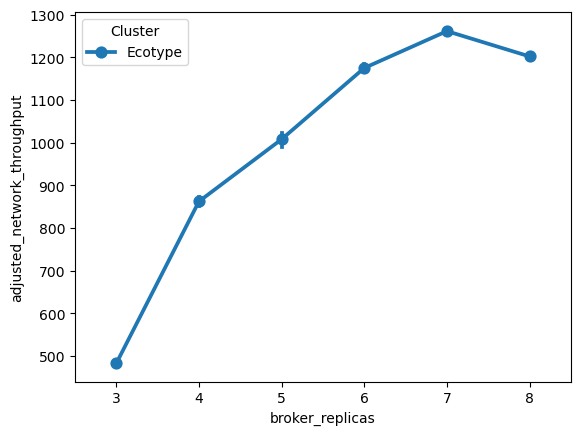

In [12]:
kafka_df['adjusted_network_throughput'] = kafka_df['throughput_MBps'] * 2
sns.pointplot(
    kafka_df,
    x='broker_replicas',
    y='adjusted_network_throughput',
    # y='throughput_MBps',
    hue="Cluster",
    )